# Experiment 2: Do V20 lake fields + some extra surface fields improve our predicitions?

We compare two models:

* `V15`: A model using time variable features + `'cl_v15','lsm_v15','dl_v15','cvl_v15','cvh_v15','anor_v15','isor_v15','slor_v15','sr_v15','lsrh_v15'`
* `V20`: A model using time variable features, the above `*_v15` fields + corresponding V20 corrections for all the 

The correction is obtained by calculating e.g. `cl_V20 - cl_V15`.

To see how these fields change when going from V15 to V20, check out the `A1.V20_vs_V15.ipynb` notebook in this directory.

---



# 1. Plot model performance and difference

We have a V15 model which has some error relative to the true, observed data.

Ditto a V20 model.

Lets plot the error maps for each of these models, and also plot the difference in the error maps.

In [324]:
import pandas as pd
import json
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs,upper_limit,lower_limit):
    
    print('Path =', path)
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)
        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        
        idxmin = np.argmin(training_loss)
        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        plt.scatter(epochs[idxmin],training_loss[idxmin])
        print('Minimum training loss:',training_loss[idxmin])

        try:
            validation_loss = d['val_loss'][i:]
            idxmin = np.argmin(validation_loss)
            plt.plot(epochs,validation_loss, label='validation loss')
            plt.scatter(epochs[idxmin],validation_loss[idxmin])
            print('Minimum validation loss:',validation_loss[idxmin])

        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')
            
            
        plt.ylim(lower_limit,upper_limit)
        print('----------------------------------------------')


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    
import seaborn as sns
def plot_distribution(df,x,bins,xlabel):
    



    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins=bins, ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel, fontsize = 20)

    ax1.axvline(0,c='0.5', linestyle='--')
    plt.show()


In [325]:
#Define the models to compare
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
#modelV15 = models_root+'ML_5f6e838711334702b2fe6d9429c1a6ae/'#v15, batchsize 1024, LR 3e-4

modelV15 = models_root+'ML_963fe7a995c546b389402f21ef5eadd7/'#As above, with sea ice
modelV20 = models_root+'ML_1bac10ad60514426934b4709e78ddfb7/' #v20. batchsize 1024, LR 3e-4. 2 hidden layers

#new bois
modelV15 = models_root+'ML_5454e45e659043d6b295aac93aede77e/'
modelV20 = models_root+'ML_bb1359c84c8845e5ac22185fc3686b96/'

#modelV20 = models_root+'ML_792ce8ee7476412face8f0c36da82287/' #v20, batchsize 1024, LR 3e-4. OLD
# ML_d360eb7b7d0a4a45ad6eb421f1994552. v15, batchsize 10,000, LR 3e-4
#ML_6102888f3be74a08ba1324385b763f16 v20, batchsize 10,000, LR 3e-4

Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_5454e45e659043d6b295aac93aede77e/
training_data: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/training_data.h5
 validation_data: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/validation_data.h5
 epochs: 100
 batch_size: 1024
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'lsm_v15', 'cl_v15', 'dl_v15', 'cvh_v15', 'cvl_v15', 'anor_v15', 'isor_v15', 'slor_v15', 'sdor_v15', 'sr_v15', 'lsrh_v15', 'si10_v15']
 optimizer: adam

Minimum training loss: 18.430255889892578
Minimum validation loss: 18.090389251708984
----------------------------------------------
Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_bb1359c84c8845e5ac22185fc3686b96/
training_data: /network/group

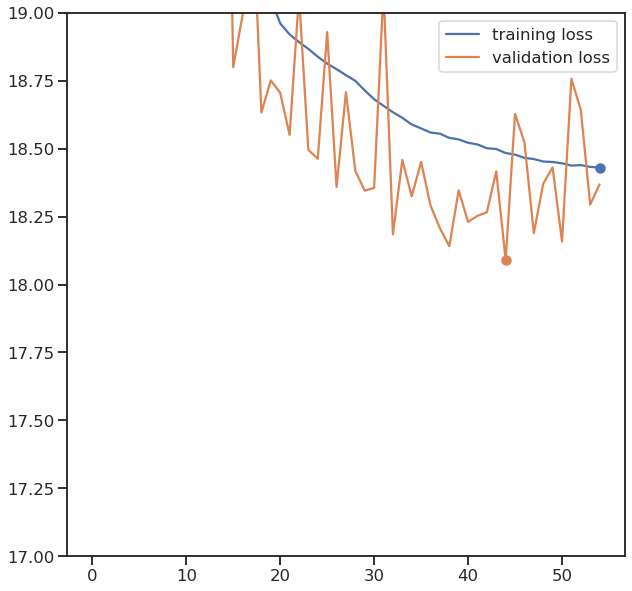

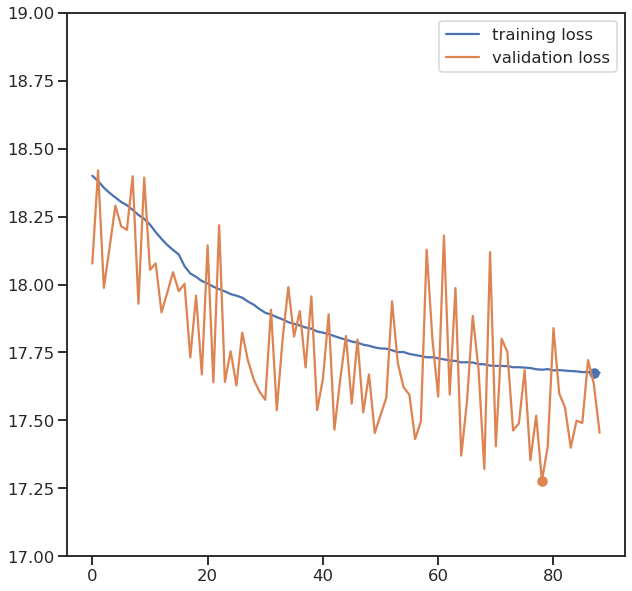

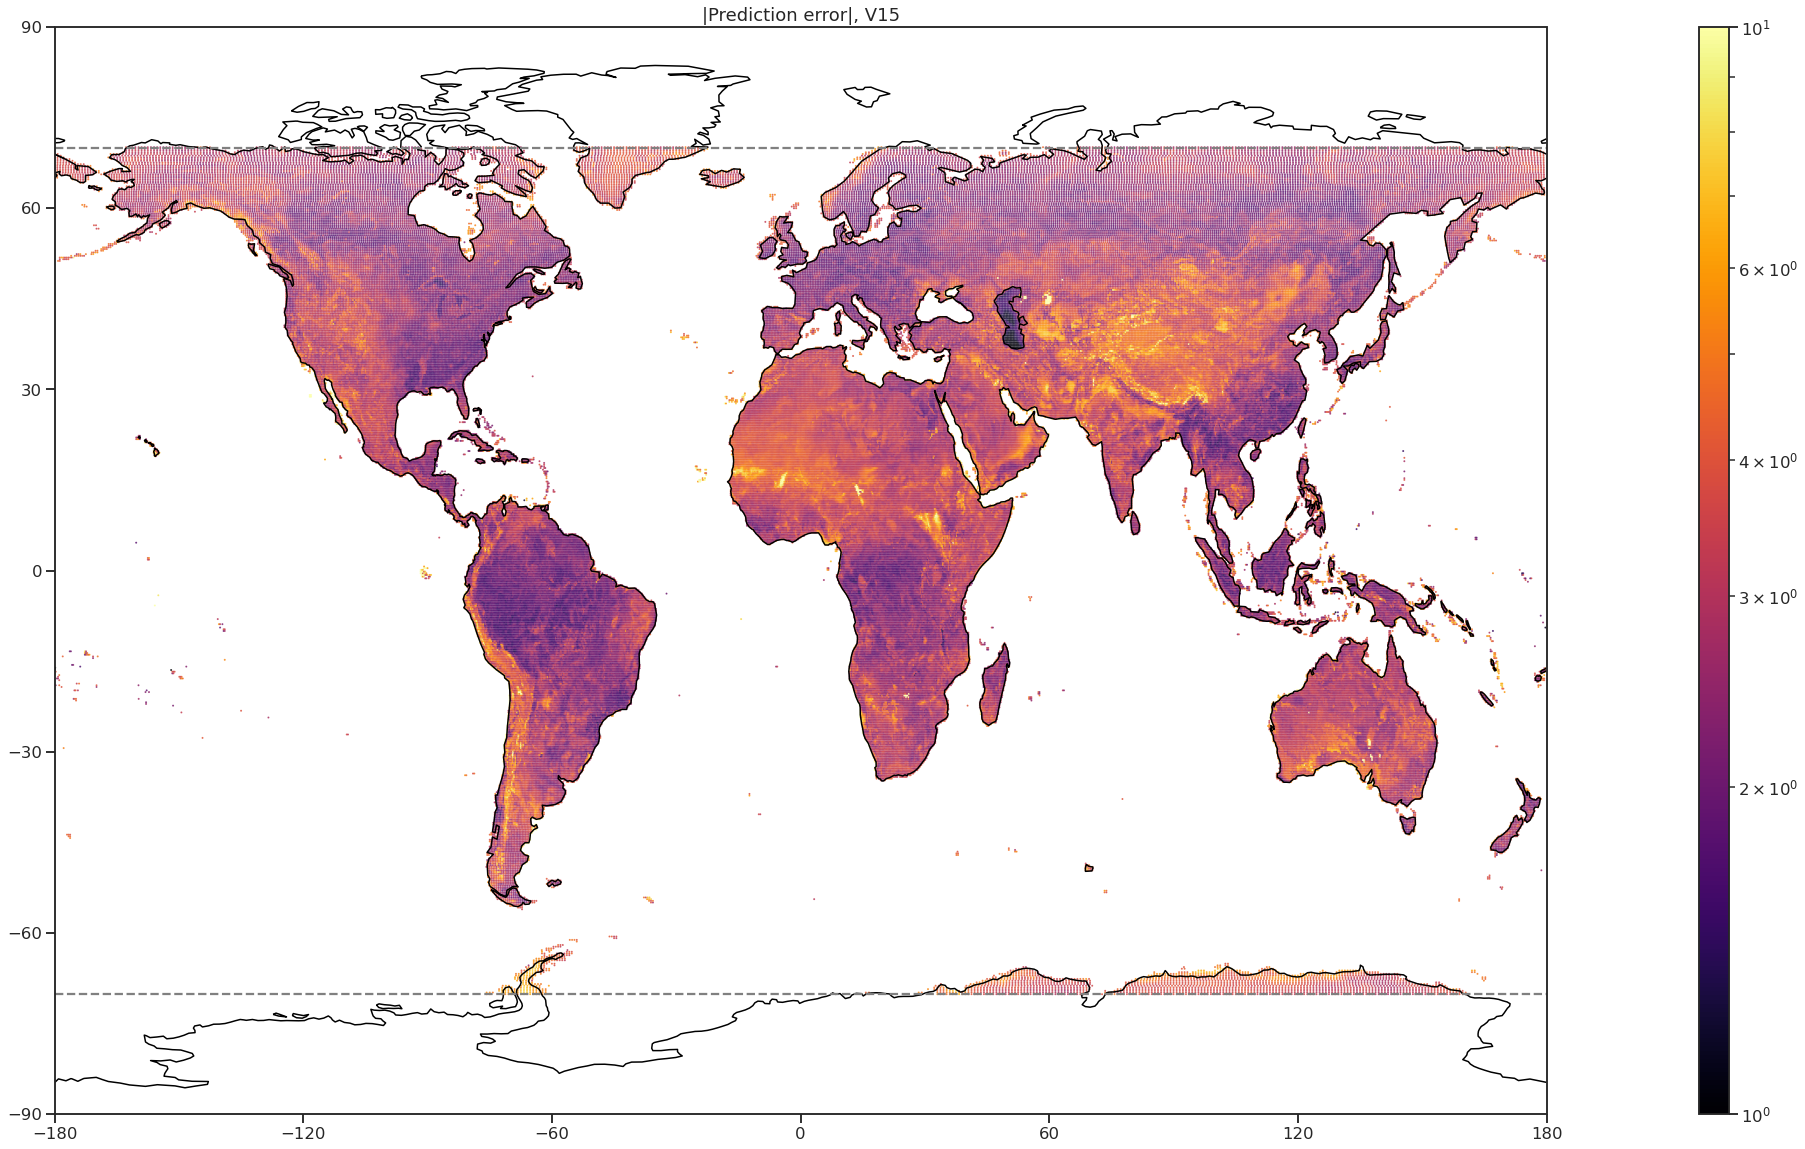

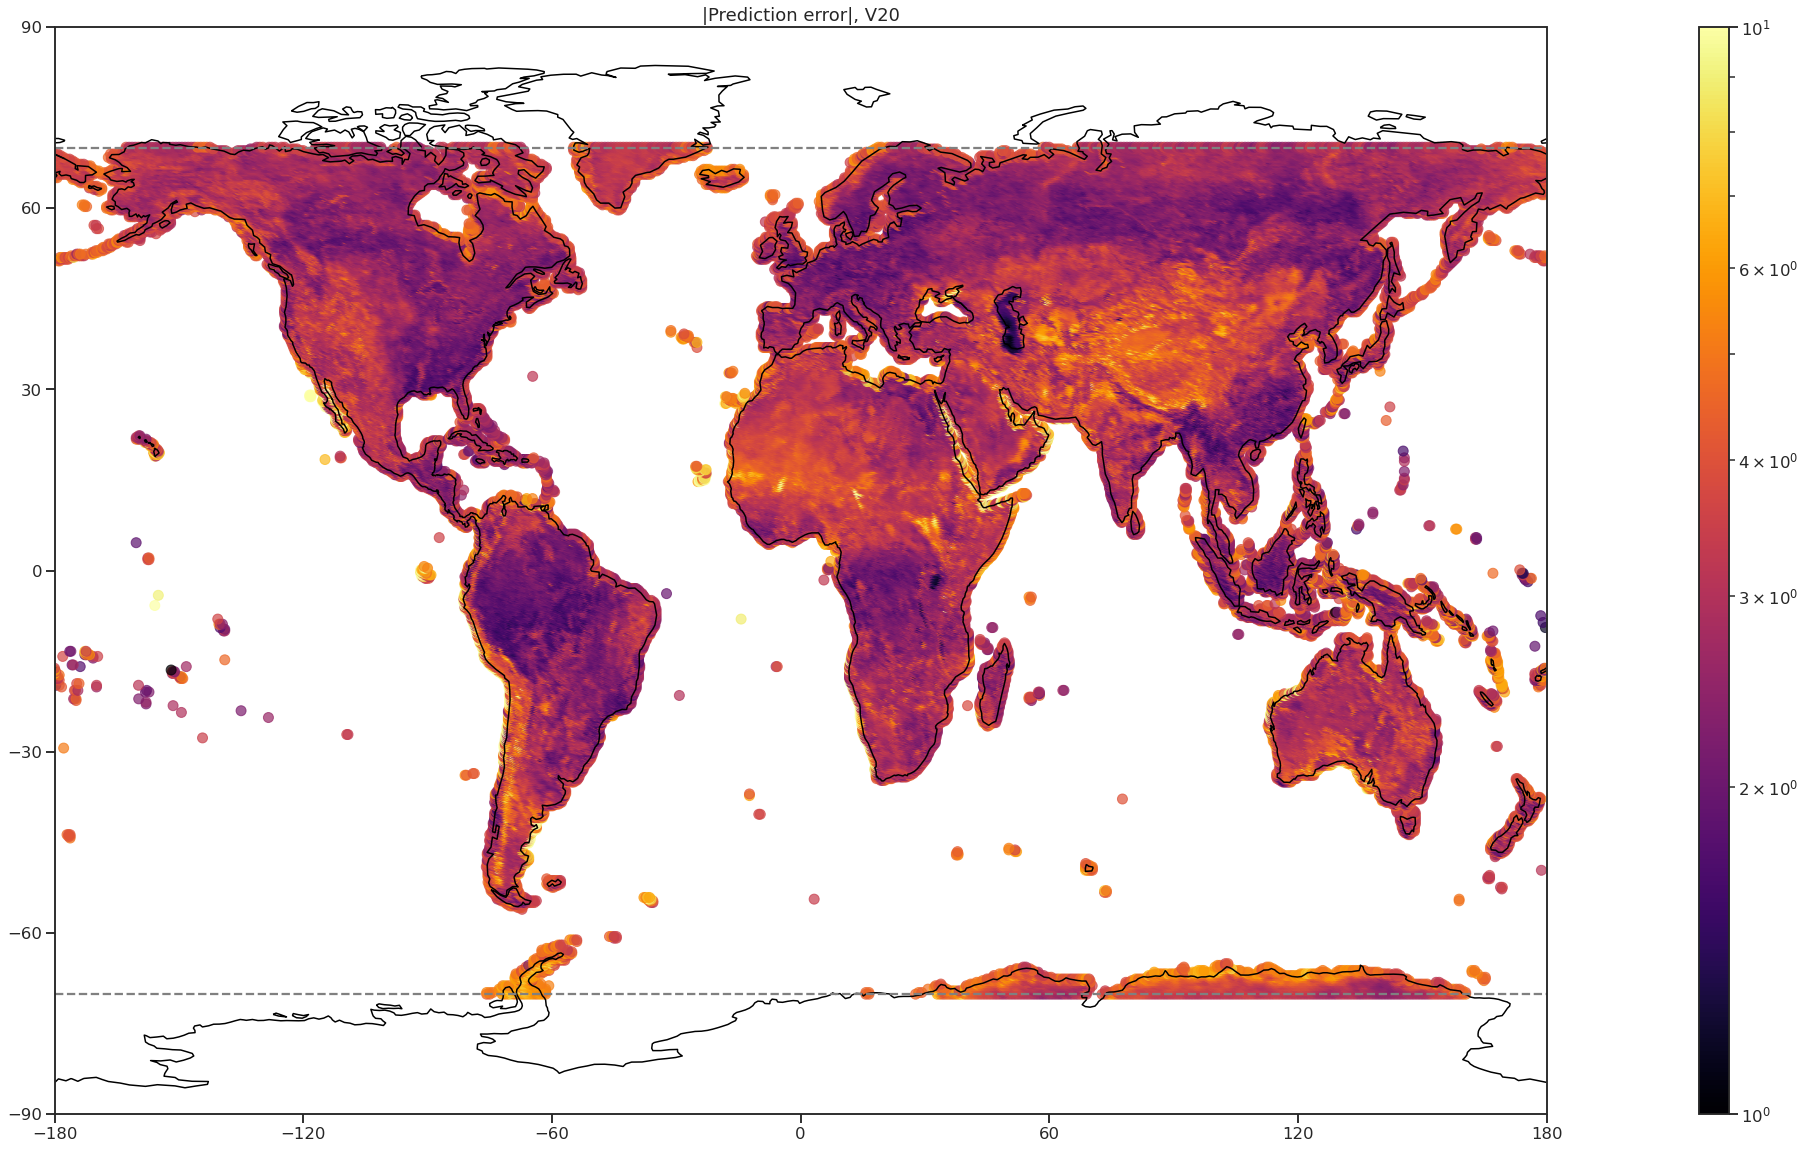

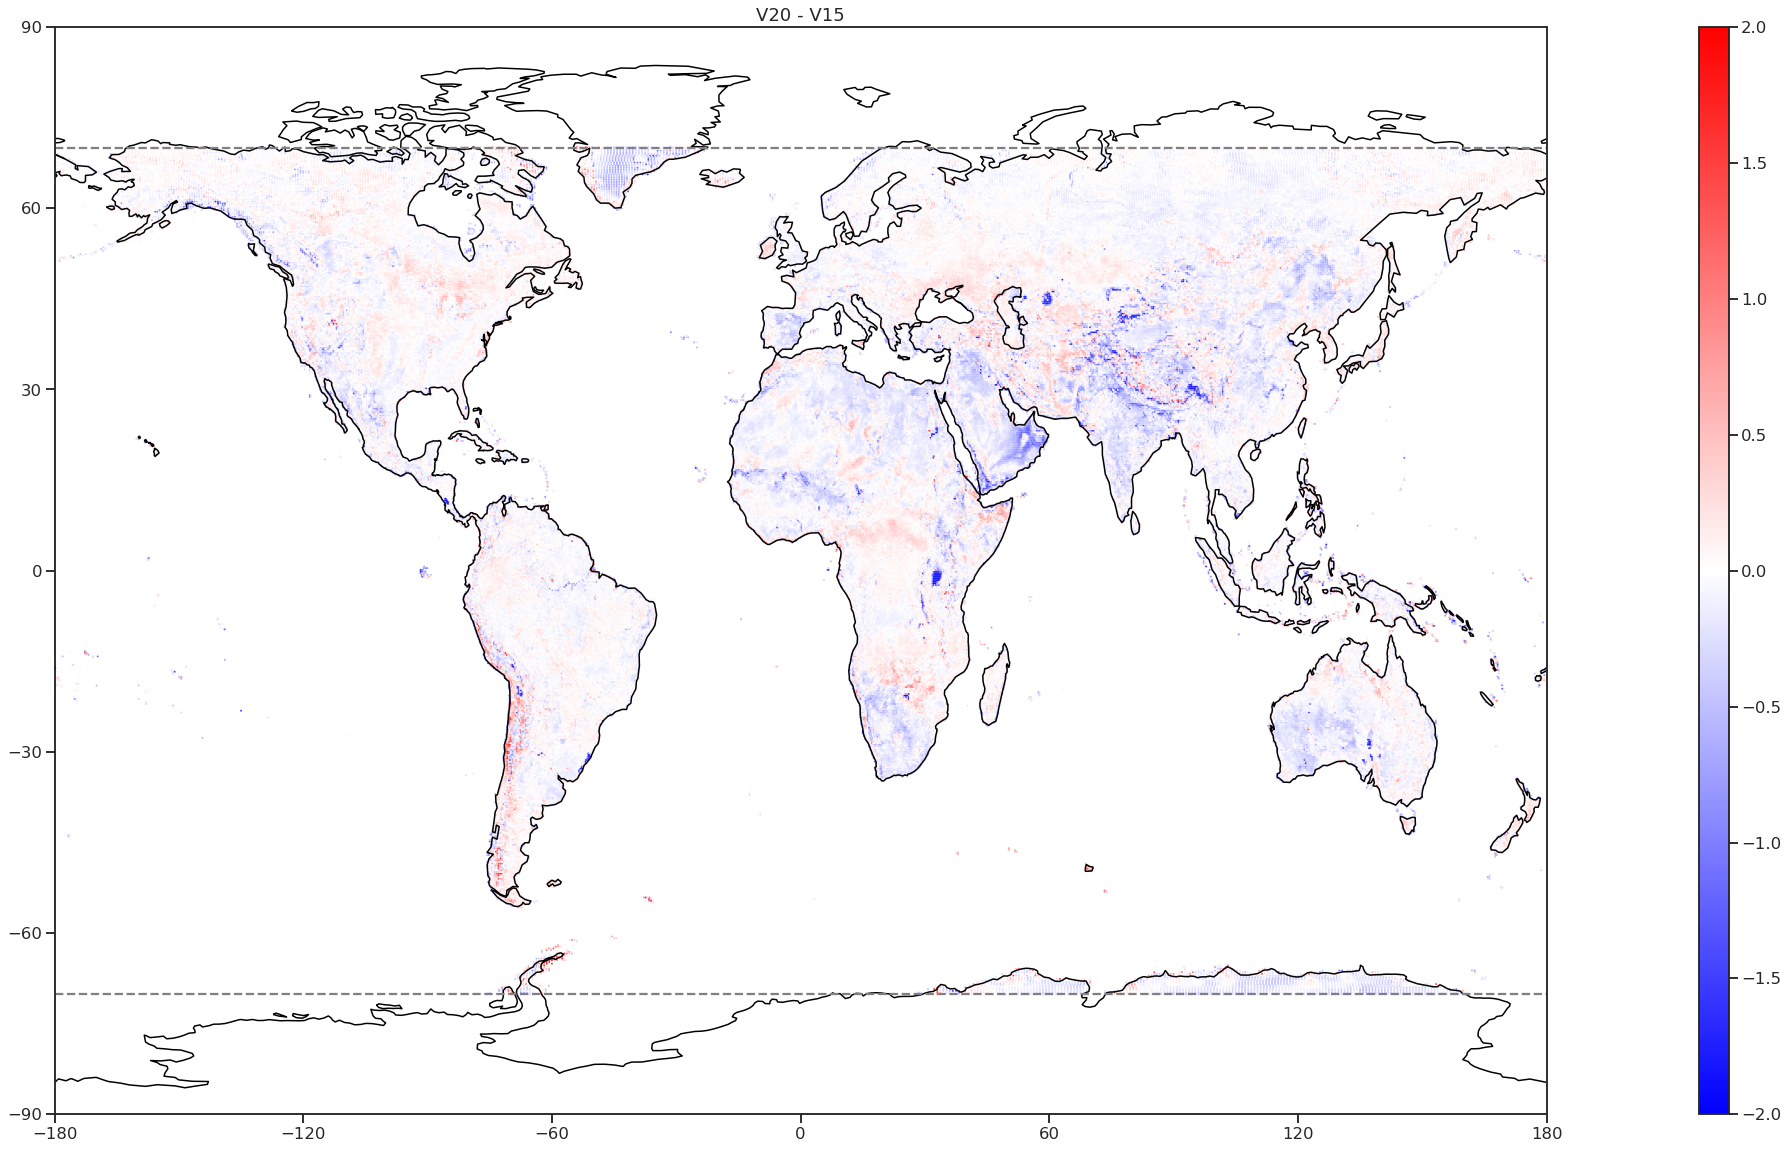

In [327]:



#Plotting parameters
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process V15
V15 = load_predictions(modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year

#Process V20
V20 = load_predictions(modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    

#Plot training history, just for interest
plot_training_history(modelV15,logscale=False,jump_n_epochs=1,upper_limit = 19,lower_limit=17) 
plot_training_history(modelV20,logscale=False,jump_n_epochs=1,upper_limit = 19,lower_limit=17)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_grouped.latitude_ERA, 
        'longitude_ERA':  V20_grouped.longitude_ERA,
        'MODIS_LST':      V20_grouped.MODIS_LST,
        'V15_prediction': V15_grouped.predictions,
        'V20_prediction': V20_grouped.predictions,
        'V15_error':      V15_grouped.absolute_model_error,
        'V20_error':      V20_grouped.absolute_model_error,
        'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
error_delta_field = pd.DataFrame(data)    
plot_map(error_delta_field,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)

---


# 2. How have the grid points changed?


In going from V15 to V20 numerous corrections have been make to e.g. lake fraction of many grid boxes.

We will now bring this information into our analysis by:

* Calculating the 'delta field' i.e. the change in certain features for each grid point
* Classifying each grid point into a particular land type

In [321]:
import xarray as xr
import pandas as pd
import numpy as np


def calculate_delta_field(filename,parameter):
    
    
    """
    Function to determine the change in a parameter when going from V15 to V20
    """
    
    root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
    version = ['v015', 'v020']
    
    ds = [] #Array to hold results
    for v in version:
        path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
        ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
        
        ds.append(ds_i)
        
    #Take the difference, and make it a nice pandas df    
    delta_field = ds[1] - ds[0] #V20 - V15
    delta_field =  delta_field.assign_coords({"longitude": (((delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
    delta_field = delta_field.to_dataframe().reset_index()
    
    V20_df = ds[1].to_dataframe().reset_index()
    V15_df = ds[0].to_dataframe().reset_index()

    if parameter == '10si': #seaice shortname is inverse to variable name
        parameter='si10'
    
    delta_field[f'V15_{parameter}'] = V15_df[parameter]
    delta_field[f'V20_{parameter}'] = V20_df[parameter]

    return delta_field





def classify_landtype(df,v):
    
    
    """
    Function to classify the land type based on the lsm/cl/seaice/cvh/cvl parameters
    """
    
    conditions = [
    #Grid boxes totally covered by water
    df[f'{v}_lsm'].eq(0.0)  & df[f'{v}_cl'].eq(0.0) & df[f'{v}_si10'].eq(0.0)  & df[f'{v}_cvh'].eq(0.0)  & df[f'{v}_cvl'].eq(0.0),  # All OCEAN
    df[f'{v}_lsm'].eq(0.0)  & df[f'{v}_cl'].ne(0.0) & df[f'{v}_si10'].eq(0.0)  & df[f'{v}_cvh'].eq(0.0)  & df[f'{v}_cvl'].eq(0.0),  # All LAKE
    
    #Grid boxes more than half covered by water: oceans or lakes?
    df[f'{v}_lsm'].ne(0.0) & df[f'{v}_lsm'].le(0.5) & df[f'{v}_cl'].eq(0.0),  #OCEAN DOMINANT
    df[f'{v}_lsm'].ne(0.0) & df[f'{v}_lsm'].le(0.5) & df[f'{v}_cl'].ne(0.0), #LAKE DOMINANT
    
    #Grid boxes more than half covered by land. Can be land/glacier/cvh/cvl
    df[f'{v}_lsm'].ne(0.0) & df[f'{v}_lsm'].ge(0.5) & df[f'{v}_si10'].eq(0.0) & df[f'{v}_cvh'].eq(0.0) & df[f'{v}_cvh'].eq(0.0), #LAND DOMINANT, no features    
    df[f'{v}_lsm'].ne(0.0) & df[f'{v}_lsm'].ge(0.5) & (df[f'{v}_si10'] > df[f'{v}_cvh']) & (df[f'{v}_si10'] > df[f'{v}_cvl']), #GLACIER DOMINANT
    df[f'{v}_lsm'].ne(0.0) & df[f'{v}_lsm'].ge(0.5) & (df[f'{v}_cvh'] > df[f'{v}_si10']) & (df[f'{v}_cvh'] > df[f'{v}_cvl']),  #CVH DOMINANT
    df[f'{v}_lsm'].ne(0.0) & df[f'{v}_lsm'].ge(0.5) & (df[f'{v}_cvl'] > df[f'{v}_si10']) & (df[f'{v}_cvl'] > df[f'{v}_cvh']),  #CVL DOMINANT

    #Errors and edge cases. Box is totally covered by water, but we get land-like things
    df[f'{v}_lsm'].eq(0.0) & df[f'{v}_cl'].eq(0.0)  & df[f'{v}_si10'].ne(0.0),  # Error GLACIER. 
    df[f'{v}_lsm'].eq(0.0) & df[f'{v}_cl'].eq(0.0)  & df[f'{v}_cvh'].ne(0.0),  # Error CVH. 
    df[f'{v}_lsm'].eq(0.0) & df[f'{v}_cl'].eq(0.0)  & df[f'{v}_cvl'].ne(0.0)  # Error CVL. 
    ]

    
    
    choices = [   "Ocean",
                  "Lake",
                  "Ocean Dominant",
                  "Lake Dominant",
                  "Land Dominant",
                  "Glacier",
                  "High Vegetation",
                  "Low Vegetation",
                  "Error: Glacier",
                  "Error: CVH",
                  "Error: CVL"
                  ]
    
    return np.select(conditions, choices,default='other')



def land_change(before,after):
    return f"Was {before}, Is {after}" 


def group_and_surface(df,sort_by,drop_unchanged_categories):
    
    """
    Function to group by Classification type and also calculate , number(+ percentage) of counts in each group, 
    along with the mean difference in the predicion error, if this information is available
    """
    
    if drop_unchanged_categories:
        df = df.query("V15LandType != V20LandType")
    
    
     #Group by the change type classification and count the number of samples in each bin
    if 'delta' in df.columns:
        classification_table = df.groupby('Classification').agg(**{'Number of Pixels':pd.NamedAgg('delta','size'),'AverageDelta':pd.NamedAgg('delta','mean')})      
        selected_columns = ['Number of Pixels','Percentage', 'AverageDelta']
       

    else:
        classification_table = df.groupby('Classification').count()
        classification_table['Number of Pixels'] = classification_table['cl'] #create a new column which we will surface
        selected_columns = ['Number of Pixels','Percentage']

    
    classification_table["Percentage"] = 100.0* classification_table['Number of Pixels'] / sum(classification_table["Number of Pixels"])


    
    return classification_table[selected_columns].sort_values(by=sort_by, ascending=False)


#Calculate all the delta fields i.e. the change in parameter V15-->V20
clake_delta_field = calculate_delta_field('clake','cl')      #How does cl change?
seaice_delta_field = calculate_delta_field('cicecap','10si') #How does seaice change
cvh_delta_field = calculate_delta_field('cvh','cvh')         #How does cvh change?
cvl_delta_field = calculate_delta_field('cvl','cvl')         #How does cvl change
lsm_delta_field = calculate_delta_field('lsmoro','lsm')      #How does lsm change?

#Bring all the delta fields together
all_delta_fields = pd.concat([clake_delta_field,seaice_delta_field,cvh_delta_field,cvl_delta_field,lsm_delta_field],axis=1)
all_delta_fields = all_delta_fields.loc[:,~all_delta_fields.columns.duplicated()] #remove duplicated column names that arise due to the concat


#Create new columns to classify the land type in V15 and V20
all_delta_fields['V15LandType'] = classify_landtype(all_delta_fields,'V15')
all_delta_fields['V20LandType'] = classify_landtype(all_delta_fields,'V20')
all_delta_fields['Classification'] = all_delta_fields.apply(lambda x: land_change(x['V15LandType'], x['V20LandType']), axis=1)

In [322]:
#Example
display(group_and_surface(all_delta_fields,sort_by='Number of Pixels',drop_unchanged_categories=False))


Number of Pixels  Percentage
Classification                                                       
Was Ocean, Is Ocean                                368694   68.014684
Was High Vegetation, Is High Vegetation             53231    9.819768
Was Low Vegetation, Is Low Vegetation               42672    7.871901
Was Land Dominant, Is Land Dominant                 41178    7.596296
Was Glacier, Is Glacier                             18113    3.341389
Was Ocean Dominant, Is Lake Dominant                 8157    1.504759
Was Ocean Dominant, Is Ocean Dominant                4298    0.792872
Was Ocean, Is Ocean Dominant                         1732    0.319510
Was Land Dominant, Is Low Vegetation                  811    0.149609
Was Lake Dominant, Is Lake Dominant                   808    0.149055
Was Lake, Is Lake                                     487    0.089839
Was Low Vegetation, Is Land Dominant                  483    0.089101
Was Ocean Dominant, Is Ocean                          285    0.052575
Was Ocean Dominant, Is Land Dominant                  155    0.028594
Was Glacier, Is Lake Dominant                         116    0.021399
Was Lake Dominant, Is Land Dominant                   108    0.019923
Was Glacier, Is Land Dominant                         107    0.019739
Was Glacier, Is Low Vegetation                         98    0.018079
Was Low Vegetation, Is Lake Dominant                   98    0.018079
Was Land Dominant, Is Lake Dominant                    85    0.015680
Was Ocean Dominant, Is Glacier                         81    0.014942
Was Land Dominant, Is Glacier                          58    0.010700
Was Error: Glacier, Is Ocean                           45    0.008301
Was Ocean, Is Lake Dominant                            39    0.007195
Was Lake, Is Lake Dominant                             24    0.004427
Was High Vegetation, Is Lake Dominant                  23    0.004243
Was Glacier, Is Ocean Dominant                         23    0.004243
Was Low Vegetation, Is Glacier                         17    0.003136
Was Land Dominant, Is Ocean                            13    0.002398
Was Land Dominant, Is Ocean Dominant                   12    0.002214
Was Error: Glacier, Is Lake Dominant                    9    0.001660
Was Lake, Is Land Dominant                              6    0.001107
Was Error: Glacier, Is Ocean Dominant                   5    0.000922
Was Glacier, Is Ocean                                   4    0.000738
Was High Vegetation, Is Glacier                         2    0.000369
Was Lake Dominant, Is Glacier                           1    0.000184
Was High Vegetation, Is other                           1    0.000184
Was High Vegetation, Is Ocean Dominant                  1    0.000184


---

# 3. Apply a mask


From the difference error map above, `V20-V15`, it is hard to disentangle regions which have changed due to the improvement of the model, versus regions which have changed simply due to the inherent variability + stochasticity during training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**. 

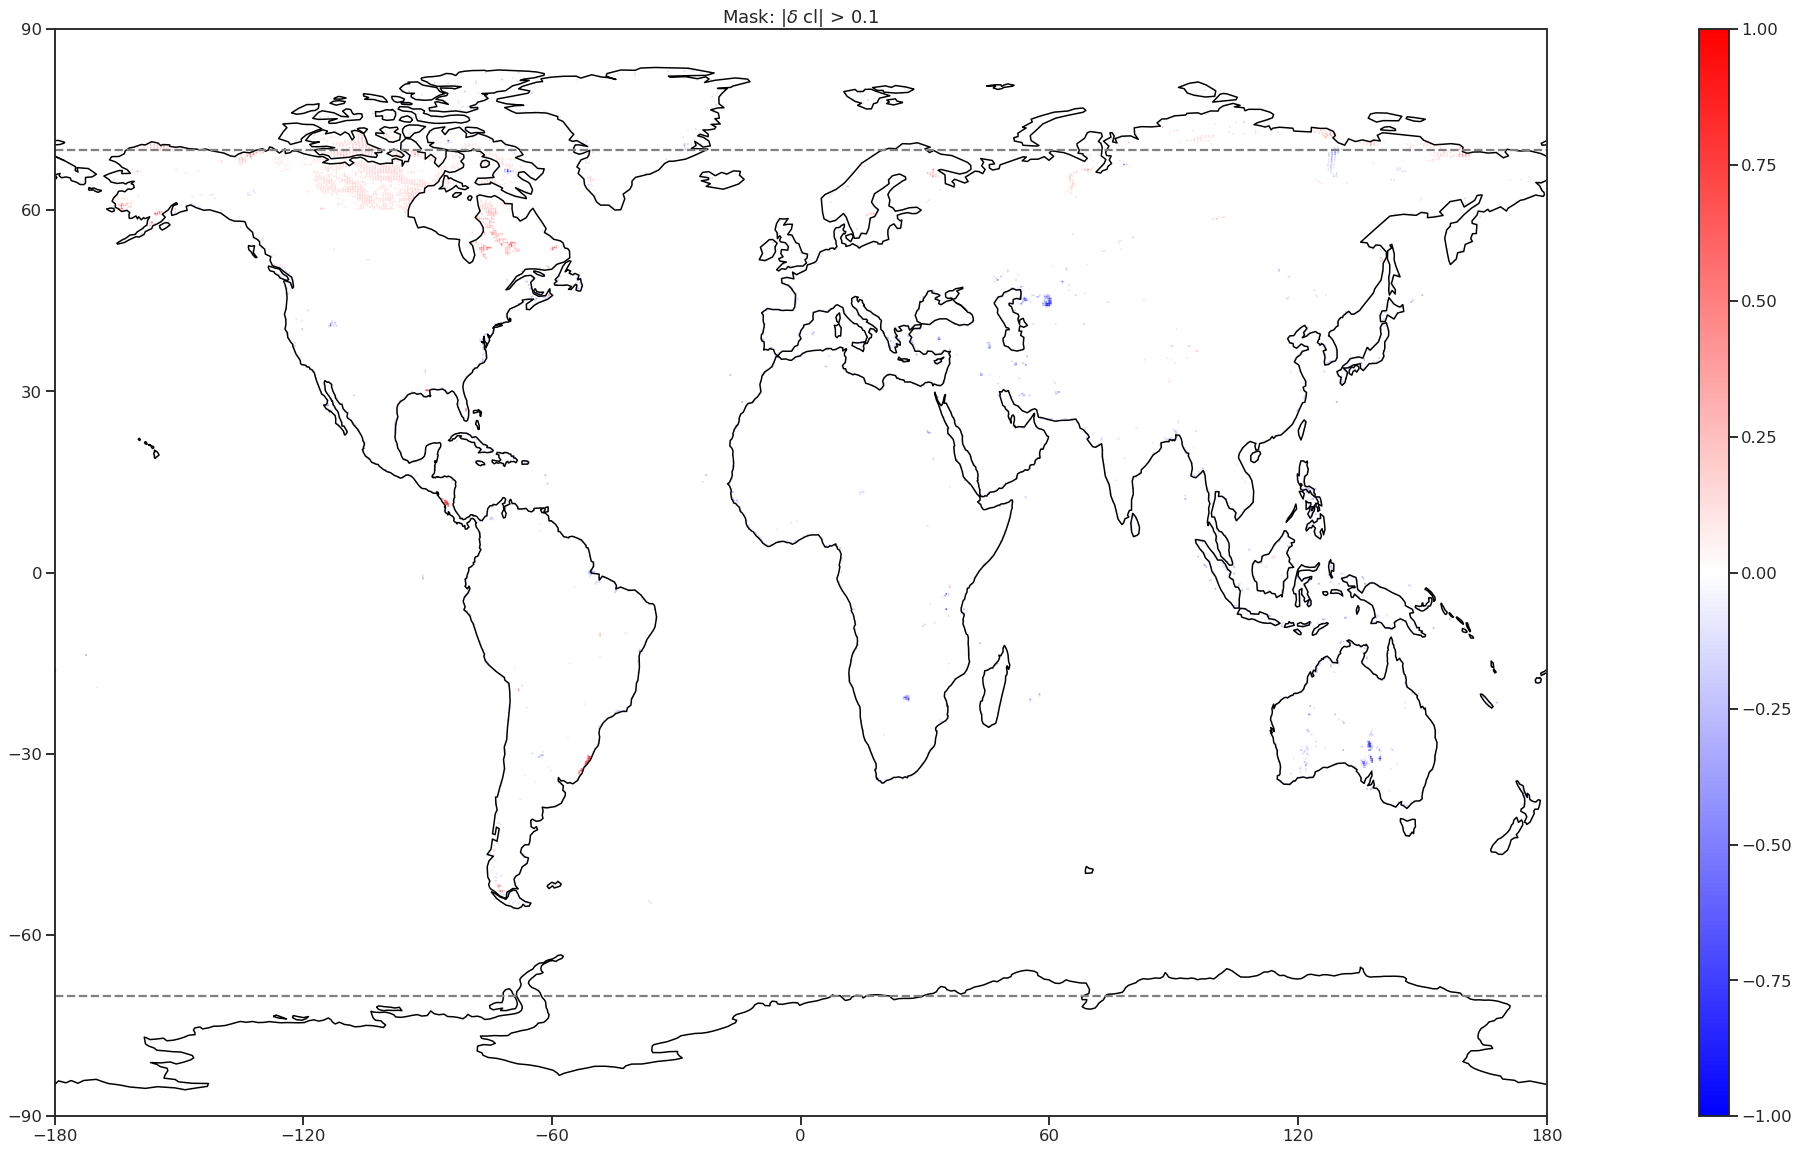

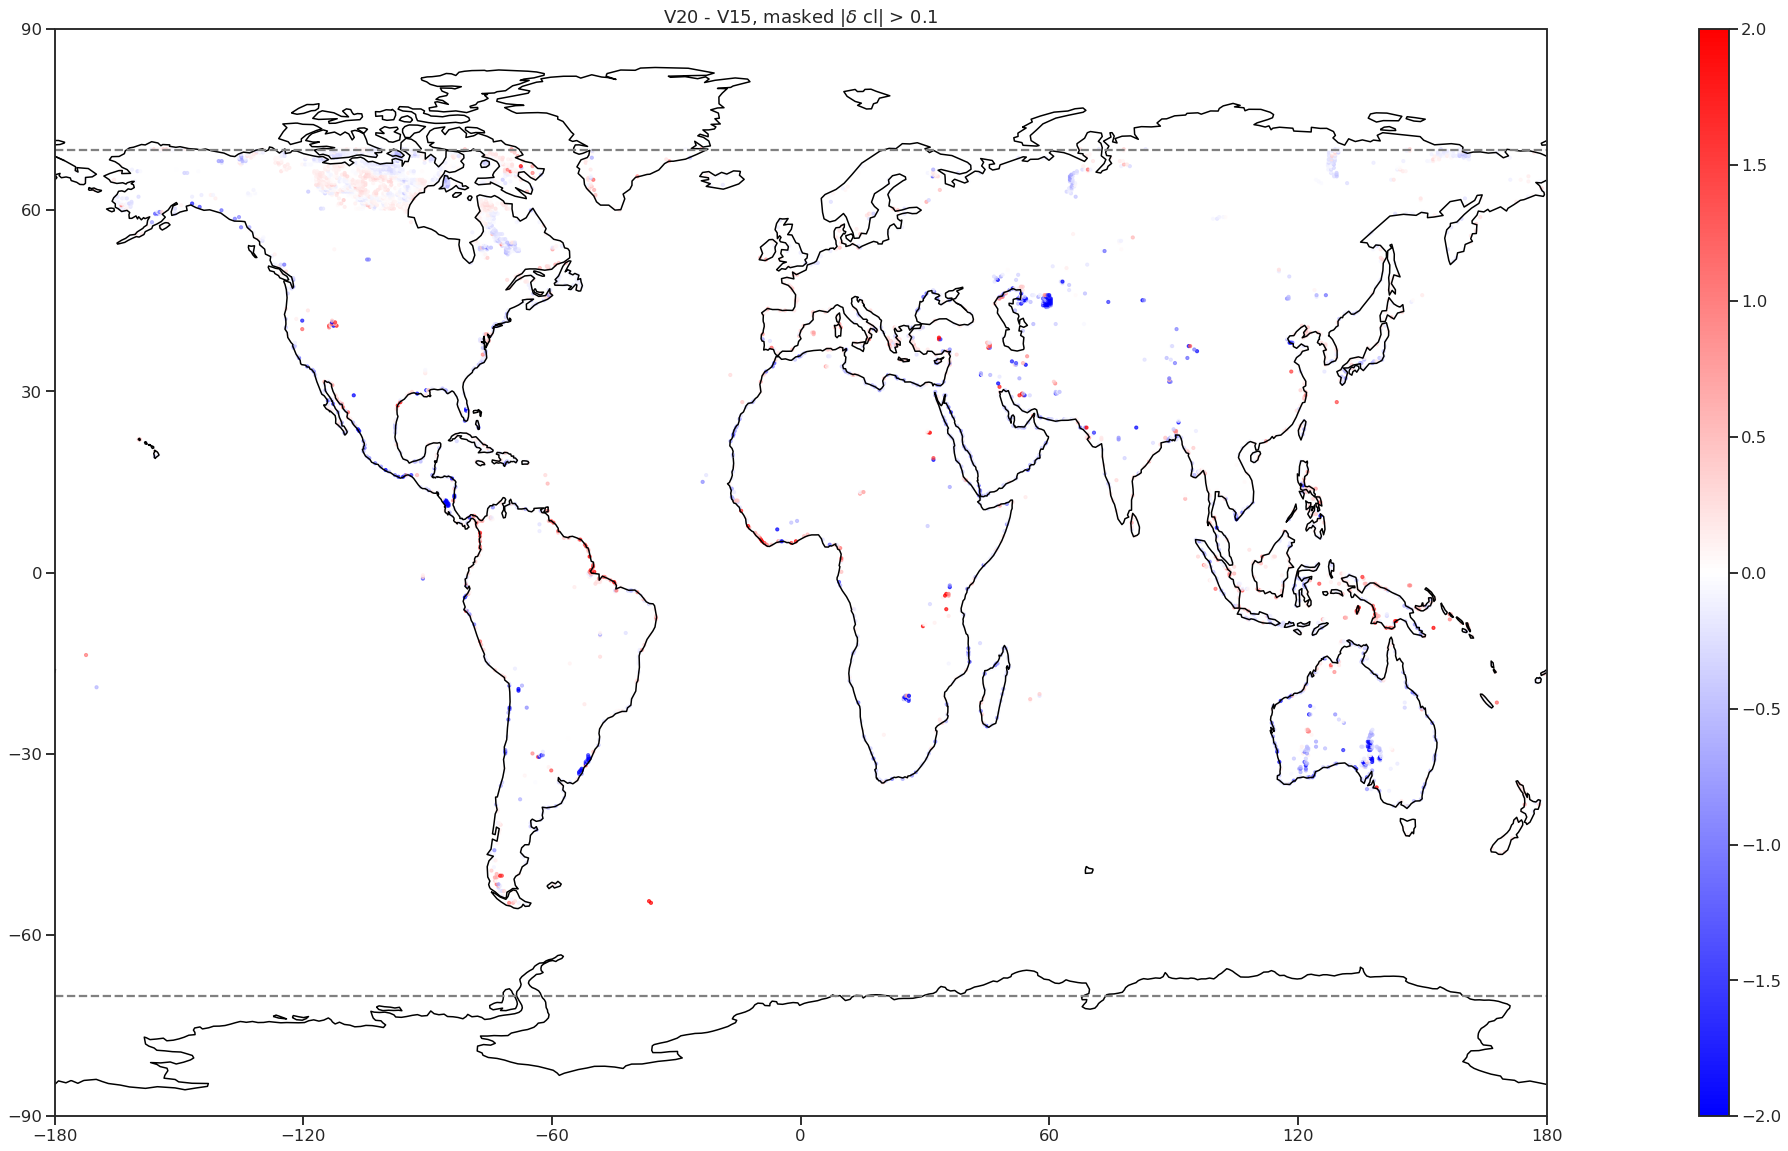

In [264]:
#Use cl delta field to create a mask 
p = 0.1 # cutoff paramter. Only get points with change in lake cover > p
mask = all_delta_fields.query(f'abs(cl) > {p}')

#Plot the mask
plot_map(mask,'cl',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=1) #What does this mask look like?


#Apply the mask to the global error_delta_field from earlier
masked_error_delta_field = pd.merge(error_delta_field,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

# Plot it, along with a distribution of the errors
plot_map(masked_error_delta_field,
         'delta',
         vmin=-2,vmax=+2,
         cmap= plt.cm.bwr,
         logscale=False,
         title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
         limits=None,
         markersize=10)
    

---


# 4. Analysis

We now have a table of errors for some grid points where the **lake parameter** has changed appreciably. Lets float some numbers: 

Mean change in model error = -0.18373166
Median change in model error = -0.037747025
Number of samples with |p| > 0.1 is: 4314
-----------------
-----------------
-----------------
Greatest improvement:


latitude_ERA  longitude_ERA  MODIS_LST  V15_prediction  V20_prediction  \
344     -28.24355       137.1875   315.2164       294.41333      310.703308   

     V15_error  V20_error      delta  values   step  ...  V20_cvh  cvl  \
344  20.803076    5.31992 -15.483156  397456 0 days  ...      0.0  0.0   

     V15_cvl  V20_cvl       lsm   V15_lsm  V20_lsm    V15LandType  \
344      0.0      0.0  0.998833  0.001167      1.0  Lake Dominant   

       V20LandType                       Classification  
344  Land Dominant  Was Lake Dominant, Is Land Dominant  

[1 rows x 32 columns]

Worst improvement: 


latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
865     -3.512879       35.15625  301.797272      301.672577      315.649017   

     V15_error  V20_error      delta  values   step  ...  V20_cvh  cvl  \
865   1.902119  13.851761  11.949641  286525 0 days  ...      0.0  0.0   

     V15_cvl  V20_cvl       lsm   V15_lsm   V20_lsm    V15LandType  \
865      0.0      0.0  0.638541  0.359505  0.998046  Lake Dominant   

       V20LandType                       Classification  
865  Land Dominant  Was Lake Dominant, Is Land Dominant  

[1 rows x 32 columns]

-----------------
-----------------
-----------------
Groupby classification 


Number of Pixels  Percentage  \
Classification                                                          
Was Land Dominant, Is Glacier                           2    0.046361   
Was High Vegetation, Is Glacier                         1    0.023180   
Was Glacier, Is Glacier                                19    0.440427   
Was Glacier, Is Low Vegetation                          6    0.139082   
Was Glacier, Is Land Dominant                           2    0.046361   
Was High Vegetation, Is Lake Dominant                   2    0.046361   
Was Lake Dominant, Is Lake Dominant                    32    0.741771   
Was Glacier, Is Lake Dominant                           2    0.046361   
Was Low Vegetation, Is Land Dominant                   56    1.298099   
Was Low Vegetation, Is Glacier                          3    0.069541   
Was High Vegetation, Is High Vegetation              1295   30.018544   
Was Land Dominant, Is Low Vegetation                    7    0.162262   
Was Low Vegetation, Is Low Vegetation                1389   32.197497   
Was Land Dominant, Is Land Dominant                  1303   30.203987   
Was Low Vegetation, Is Lake Dominant                   12    0.278164   
Was Land Dominant, Is Lake Dominant                    20    0.463607   
Was Ocean Dominant, Is Land Dominant                    6    0.139082   
Was Ocean Dominant, Is Lake Dominant                   81    1.877608   
Was Ocean, Is Lake Dominant                             1    0.023180   
Was Lake, Is Lake Dominant                              1    0.023180   
Was Lake Dominant, Is Land Dominant                    68    1.576263   
Was Lake, Is Land Dominant                              6    0.139082   

                                         AverageDelta  \
Classification                                          
Was Land Dominant, Is Glacier                3.735730   
Was High Vegetation, Is Glacier              1.193464   
Was Glacier, Is Glacier                      0.492105   
Was Glacier, Is Low Vegetation               0.250499   
Was Glacier, Is Land Dominant                0.198129   
Was High Vegetation, Is Lake Dominant        0.160817   
Was Lake Dominant, Is Lake Dominant          0.152933   
Was Glacier, Is Lake Dominant                0.124630   
Was Low Vegetation, Is Land Dominant         0.071618   
Was Low Vegetation, Is Glacier               0.050255   
Was High Vegetation, Is High Vegetation      0.016752   
Was Land Dominant, Is Low Vegetation        -0.058509   
Was Low Vegetation, Is Low Vegetation       -0.064220   
Was Land Dominant, Is Land Dominant         -0.148414   
Was Low Vegetation, Is Lake Dominant        -0.161544   
Was Land Dominant, Is Lake Dominant         -0.331344   
Was Ocean Dominant, Is Land Dominant        -1.055508   
Was Ocean Dominant, Is Lake Dominant        -1.195846   
Was Ocean, Is Lake Dominant                 -2.723682   
Was Lake, Is Lake Dominant                  -3.178854   
Was Lake Dominant, Is Land Dominant         -5.572563   
Was Lake, Is Land Dominant                 -10.709850   

                                                         Stats (t-statistic,p-value)  \
Classification                                                                         
Was Land Dominant, Is Glacier              (-1.6296863407240538, 0.2447282344270457)   
Was High Vegetation, Is Glacier                                                  NaN   
Was Glacier, Is Glacier                    (-1.5965235089237955, 0.1191141619137242)   
Was Glacier, Is Low Vegetation             (-0.6342726477861572, 0.5401404857917074)   
Was Glacier, Is Land Dominant             (-1.9742645400080816, 0.18705109082965482)   
Was High Vegetation, Is Lake Dominant      (-0.4596636854950579, 0.6908869966600747)   
Was Lake Dominant, Is Lake Dominant          (-0.2593622066407684, 0.79621504414744)   
Was Glacier, Is Lake Dominant             (-0.12708059628601762, 0.9105010623869608)   
Was Low Vegetation, Is Land Dominant   

Baseline variabiity (Mean delta , number of samples)
Lake: -0.056883123 462
Lake Dominant nan 0
Land: -0.0890165 24323
Glacier: -0.2946902 1636
CVH: -0.0005718191 30042
CVL: -0.016180582 405
-----------------
-----------------
-----------------


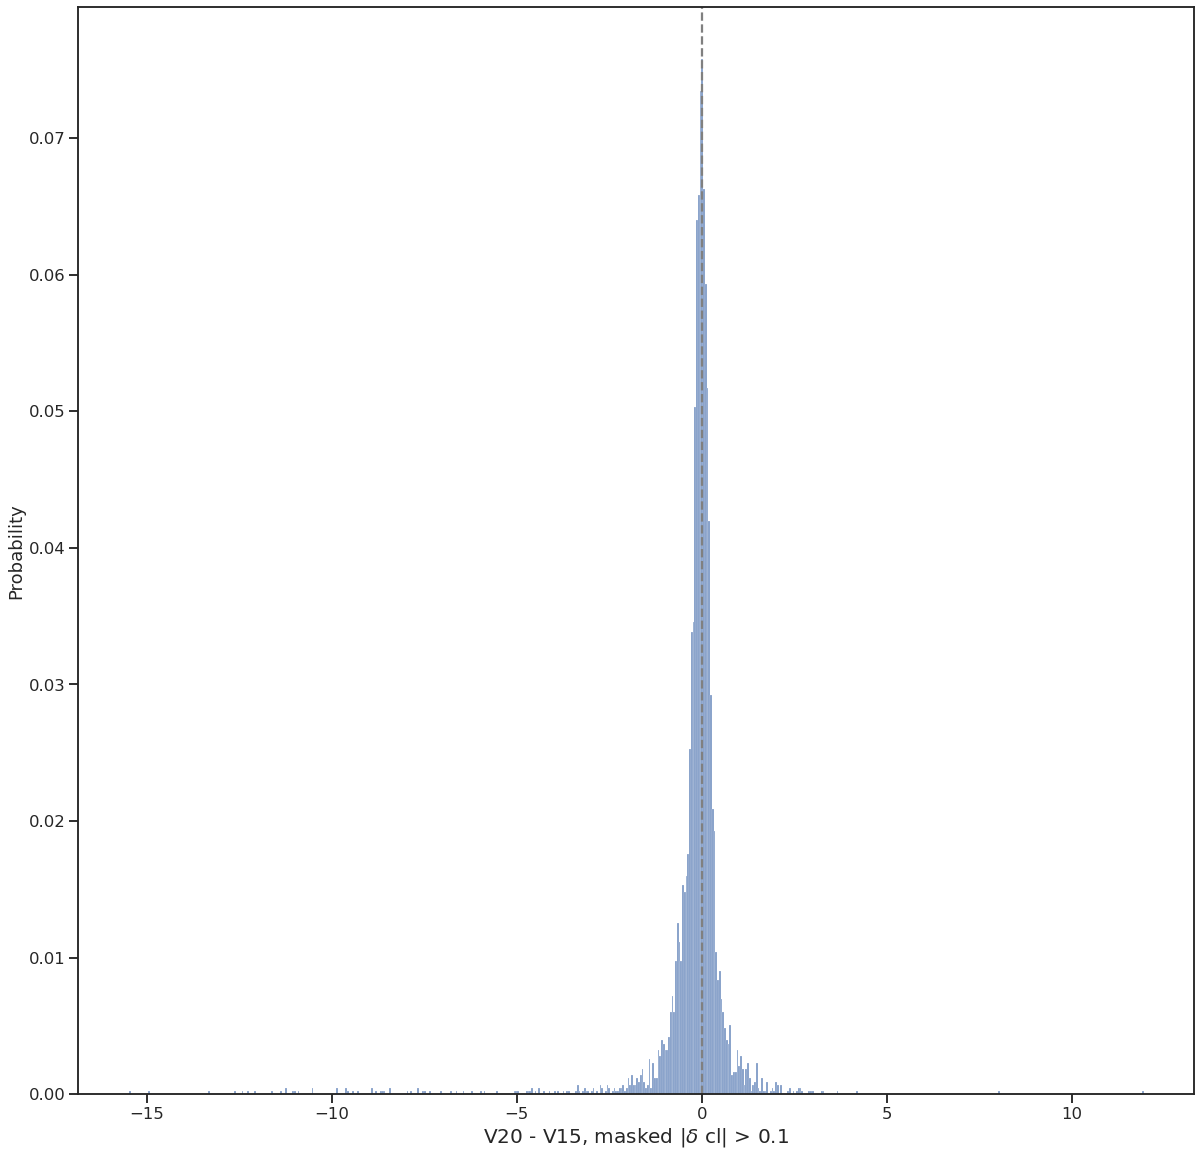

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
865      -3.512879      35.156250  301.797272      301.672577      315.649017   
792      -6.042153      35.156250  305.171234      303.088135      315.660065   
7       -54.379367     -36.562500  275.672150      271.234863      265.554260   
780      -6.323183     -80.718750  312.704468      300.203339      296.515869   
5       -54.660397     -36.093750  274.088196      272.432800      267.986725   
1848     27.681490     -97.200000  303.101715      302.753448      297.042419   
1902     29.648702      53.437500  307.886749      309.075104      313.022064   
123     -35.550339     139.000000  297.752625      295.461212      289.737549   
771      -6.885244     138.656250  299.142059      302.267426      305.380829   
30      -50.163913     -72.500000  283.333252      282.680939      278.298706   
3913     67.306750     -67.500000  259.246826      258.427063      254.158981   
2228     38.922703      33.398438  299.800690      300.101532      304.768372   
1025      0.140515     -49.781250  301.715790      302.825378      306.347778   
1024      0.140515     -50.343750  299.773956      302.862183      305.627686   
1750     24.028095      69.000000  313.644440      302.867462      300.260254   
857      -3.793910      34.875000  305.867157      309.081543      312.050934   
1716     23.185004      31.200000  311.227936      317.036224      319.452911   
956      -1.545667     -45.000000  301.744965      303.838318      306.523560   
1863     28.243550     -96.562500  302.229370      302.226196      297.617920   
2221     38.641672      33.398438  298.259216      294.325348      305.499268   

      V15_error  V20_error      delta  values   step  ...   V20_cvh       cvl  \
865    1.902119  13.851761  11.949641  286525 0 days  ...  0.000000  0.000000   
792    2.465827  10.488852   8.023025  298045 0 days  ...  0.000000  0.000000   
7      6.256880  10.443961   4.187081  490445 0 days  ...  0.000000  0.000000   
780   12.517011  16.188610   3.671599  300193 0 days  ...  0.000000  0.000000   
5      3.498004   6.782382   3.284379  491214 0 days  ...  0.000000  0.000000   
1848   2.865633   6.106263   3.240630  147091 0 days  ...  0.000000  0.000000   
1902   2.153452   5.144741   2.991289  138322 0 days  ...  0.014374 -0.000003   
123    5.559628   8.505439   2.945811  426720 0 days  ...  0.000000  0.000000   
771    3.315521   6.238758   2.923238  302253 0 days  ...  0.697998 -0.000013   
30     3.047160   5.743083   2.695924  477977 0 days  ...  0.217834  0.000015   
3913   3.372694   6.055559   2.682865   21916 0 days  ...  0.000000  0.000007   
2228   2.352317   5.016133   2.663816  102000 0 days  ...  0.020142 -0.000009   
1025   2.014502   4.631983   2.617481  270863 0 days  ...  0.707550  0.000008   
1024   3.244111   5.853716   2.609605  270861 0 days  ...  0.558807 -0.000007   
1750  10.786755  13.384185   2.597430  162045 0 days  ...  0.000000  0.000000   
857    3.732663   6.224461   2.491798  287804 0 days  ...  0.215027 -0.000003   
1716   5.839687   8.224980   2.385293  165519 0 days  ...  0.000000 -0.000010   
956    2.407100   4.780948   2.373848  278560 0 days  ...  0.622925  0.000006   
1863   2.357867   4.712727   2.354860  144754 0 days  ...  0.000000  0.000000   
2221   5.204159   7.366322   2.162162  103024 0 days  ...  0.000000  0.000000   

       V15_cvl   V20_cvl       lsm   V15_lsm   V20_lsm      V15LandType  \
865   0.000000  0.000000  0.638541  0.359505  0.998046    Lake Dominant   
792   0.000000  0.000000  0.727888  0.247836  0.975724    Lake Dominant   
7     0.000000  0.000000 -0.007348  0.850562  0.843214    Land Dominant   
780   0.000000  0.000000  0.132594  0.243522  0.376116   Ocean Dominant   
5     0.000000  0.000000 -0.000697  0.833394  0.832696    Land Dominant   
1848  0.000000  0.000000  0.023923  0.200809  0.224732   Ocean Dominant   
1902  0.673373  0.673370  0.348912  0.643640  0.992552   Low Vegetation   
12

In [323]:
from scipy.stats import ttest_ind

def significance_test(v1,v2):
    try:
        return ttest_ind(v1, v2)
    except:
        return np.nan

import warnings
warnings.filterwarnings("error")  

def significance_boolean(x):
    
    try:
        pval = x[-1]
    except:
        #Nans are not subscriptable
        return 'Insignificant'
    
    if (pval > 0.01) or np.isnan(pval): 
        return 'Insignificant'
    else:
        return 'Significant'
    


def calculate_variability(condition):

    stationary_mask = all_delta_fields.query(condition) 
    stationary_errors = pd.merge(error_delta_field,stationary_mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

    return stationary_errors.delta.mean(),stationary_errors.delta.count() #The mean improvement in going from V15 to V20 for these points

#Get the mean change/delta in V15/V20 for grid points which WERE NOT CHANGED
#This gives us an inherent variability for those categories which were unchanged
lake_variability, lake_variability_samples        = calculate_variability(f'abs(cl) == 0.0 & V15LandType == "Lake"')
lake_dom_variability,lake_dom_variability_samples = calculate_variability(f'abs(cl) == 0.0 & V15LandType == "Lake Dominant"')
land_variability,land_variability_samples         = calculate_variability(f'abs(lsm) == 0.0 & V15LandType == "Land Dominant"')
glacier_variability,glacier_variability_samples   = calculate_variability(f'abs(si10) == 0.0 & V15LandType == "Glacier"')
cvh_variability,cvh_variability_samples           = calculate_variability(f'abs(cvh) == 0.0 & V15LandType == "High Vegetation"')
cvl_variability,cvl_variability_samples           = calculate_variability(f'abs(cvl) == 0.0 & V15LandType == "Low Vegetation"')









#Means and Medians
print('Mean change in model error =', masked_error_delta_field.delta.mean())
print('Median change in model error =', masked_error_delta_field.delta.median())

#Number of grid points
print (f'Number of samples with |p| > {p} is:',  len(masked_error_delta_field))

print ('-----------------')
print ('-----------------')
print ('-----------------')

#Best and worst areas
print ('Greatest improvement:')
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.min()])  #small numbers show V20 > V15
print ('Worst improvement: ') 
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.max()])  #Large numbers show V20 < V15



print ('-----------------')
print ('-----------------')
print ('-----------------')


#Group by classification, and also calculate some variabilities/significances

print ('Groupby classification ')         
classification_table = group_and_surface(masked_error_delta_field,sort_by='AverageDelta',drop_unchanged_categories=False)
significance_table = tmp.groupby('Classification').apply(lambda x: significance_test(x['V15_error'], x['V20_error'])) 
classification_table['Stats (t-statistic,p-value)'] = significance_table
classification_table['Significant Change?'] = classification_table['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))

display(classification_table)




print ('Baseline variabiity (Mean delta , number of samples)')
print('Lake:',lake_variability, lake_variability_samples)        
print('Lake Dominant',lake_dom_variability,lake_dom_variability_samples)  
print('Land:',land_variability,land_variability_samples)         
print('Glacier:',glacier_variability,glacier_variability_samples)   
print('CVH:',cvh_variability,cvh_variability_samples)           
print('CVL:',cvl_variability,cvl_variability_samples)           



print ('-----------------')
print ('-----------------')
print ('-----------------')


#Distribution of errors
plot_distribution(masked_error_delta_field,
                  'delta',
                  bins='auto',
                  xlabel = f'V20 - V15, masked |${{\\delta}}$ cl| > {p}')



#Header of table
display(masked_error_delta_field.sort_values(by=['delta'],ascending=False).head(20))


# Appendix

Old material

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = " counts",
    arrangement='snap',

    #Define nodes 
    
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = categories,
      color = "blue",
     #x=[0,0,0],
     #y=[0,1,2]
    ),
    link = dict(
      source = source_idx, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_idx,
      value =  values
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10,width=800, height=800)
fig.show()

In [ ]:






#Get a map of the original V15 lsm. This will only be used to get rid of oceans
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
lsm_path = root+f'climate.v015/climate.v015/639l_2/lsmoro'
ds_lsm= xr.open_dataset(lsm_path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'lsm'}) 
ds_lsm = correct_longitude(ds_lsm)
lsm_df = ds_lsm.to_dataframe().reset_index() #Make it a df
all_fields = lsm_df.copy()



#Now look at all the features which are changing
changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


for i in range(len(changing_features)): 
    file = changing_files[i]
    feature=changing_features[i]
    delta = difference_in_surface_fields(file,feature)
    
    all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
print ('Plotting map of changing features')
for f in changing_features: 
    plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)
    
    
# #We can define some masks based on how we want to filter the data
# strong_mask = all_fields.query('abs(delta_cl) > 0.1 & abs(delta_lsm) > 0.0 & abs(delta_dl)>0.0 & abs(delta_cvl) > 0.0 & abs(delta_cvh) > 0.0')
# weak_mask = all_fields.query('abs(delta_cl) > 0.1')

# plot_map(all_fields,'delta_cl',vmin=-0.05,vmax=+0.01,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover',limits=limits,markersize=1)
# plot_map(strong_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Strong Mask: Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?
# plot_map(weak_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Weak Mask, Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?





# #Now look at all the features which are changing
# changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
# changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


# for i in range(len(changing_features)): 
#     file = changing_files[i]
#     feature=changing_features[i]
#     delta = difference_in_surface_fields(file,feature)
    
#     all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
# print ('Plotting map of changing features')
# for f in changing_features: 
#     plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)

    

In [ ]:
# from matplotlib.gridspec import GridSpec
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import xarray as xr
# import matplotlib.colors as mc
# import matplotlib.colorbar as cb 




# def correct_longitude(ds):    
#     return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


# def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
#     """Scatter plot. Bit hacky. """

#     try:
#         x = ds.longitude
#         y = ds.latitude
#     except: #different sources call lat/lon different things
#         x = ds.longitude_ERA
#         y = ds.latitude_ERA
    
#     z1 = ds[z]
    

    
#     #Setup figure and axes
#     fig = plt.figure(figsize=[30,20])
#     gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
#     ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
#     cax = fig.add_subplot(gs[1])
    
#     #Cmaps, normalisations
#     if logscale:
#         norm = mc.LogNorm(vmin=vmin, vmax=vmax)
#         z1 = abs(z1)
#     else:
#         norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
#     cb1 = cb.ColorbarBase(cax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
    
    
    
#     #Plot it
#     sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
#                 linewidths=1, alpha=.7)

    
#     #Tidy up
#     ax.axhline(70, c='0.5', linestyle='--')
#     ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

#     ax.set_title(title)    
#     ax.coastlines()

    
#     ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
#     ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#     ax.set_aspect('auto') #Force projection aspect ratio
    
#     if limits is not None:
#         ax.set_xlim(limits['xlow'],limits['xhigh'])
#         ax.set_ylim(limits['ylow'],limits['yhigh'])
#         ax.set_xticks([])
#         ax.set_yticks([])

#     plt.show()
    
    
    
    
# def difference_in_surface_fields(file,feature):
    
    
#     version = ['v015', 'v020']
    
#     ds = [] #Array to hold results
#     for v in version:
#         path = root+f'climate.{v}/climate.{v}/639l_2/{file}'
#         ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': feature}) 
#         ds.append(ds_i)
        
        
    
#     #Take the difference    
#     delta = ds[1] - ds[0] #V20 - V15
#     delta = correct_longitude(delta) #long3 ---> long1
    
#     return delta
    